# Model analysis

Validation results taken from pretrained model of RetinaNet (R-50-FPN) from here: https://github.com/SysCV/bdd100k-models/tree/main/det

Here is an analysis on the results

In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd
import numpy as np
from losses import calculate_metrics_wrapped
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pickle
import json


In [2]:
pred_df = pd.read_parquet('/Users/ashutoshtaklikar/Desktop/Bosch_Interview/bdd100k_val_cache_predictions.parquet')
gt_df = pd.read_parquet('/Users/ashutoshtaklikar/Desktop/Bosch_Interview/bdd100k_val_cache.parquet')

In [3]:
score_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9][::-1]
iou_thresholds = [0.5, 0.75, 0.9]
all_categories = gt_df['category_name'].unique().tolist() + ['all']
all_categories = all_categories[::-1]

In [4]:
# Lets calculate the metrics over multiple score thresholds
METRICS_FILE_SAVE_NAME = 'all_metrics_data.parquet'
folder_path = '/Users/ashutoshtaklikar/Desktop/Bosch_Interview/metrics_saved/'

metrics = []
futures = []
os.makedirs(folder_path, exist_ok=True)
with ProcessPoolExecutor(max_workers=8) as executor:
    for curr_cat in all_categories:
        if curr_cat != 'all':
            curr_cat_gt_df = gt_df[gt_df['category_name'] == curr_cat]
            curr_cat_pred_df = pred_df[pred_df['category_name'] == curr_cat]
        else:
            curr_cat_gt_df = gt_df
            curr_cat_pred_df = pred_df

        for score_threshold in score_thresholds:
            curr_score_pred_df = curr_cat_pred_df[curr_cat_pred_df['score'] >= score_threshold]
            curr_score_gt_df = curr_cat_gt_df

            for iou_threshold in iou_thresholds:
                if os.path.exists(os.path.join(folder_path, f"cat-{curr_cat}_score-{score_threshold}_iou-{iou_threshold}.parquet")):
                    print("Already done, skipping")
                    continue                
                futures.append(executor.submit(calculate_metrics_wrapped, curr_score_pred_df, curr_score_gt_df, iou_threshold, curr_cat, score_threshold))

    for future in tqdm(as_completed(futures), total=len(futures), desc="Calculating metrics over all categories, score_thresholds and iou_thresholds"):
        try:
            curr_result = future.result()
            curr_df = pd.DataFrame(curr_result['metrics'])
            curr_df.to_parquet(os.path.join(folder_path, f"cat-{curr_result['category']}_score-{curr_result['score_threshold']}_iou-{curr_result['iou_threshold']}.parquet"))
            metrics.append(curr_result)
            print(f"Done for {curr_result['category']} {curr_result['score_threshold']} {curr_result['iou_threshold']}")
        except Exception as e:
            print(f"Error occurred: {e}")

metrics_df = pd.DataFrame(metrics)
df_save_path = os.path.join(folder_path, METRICS_FILE_SAVE_NAME)
metrics_df.to_parquet(df_save_path)

print("Done for all categories, score_thresholds and iou_thresholds")
print(f"Metrics saved as a DF at {df_save_path}")

Calculating metrics over all categories, score_thresholds and iou_thresholds:   0%|          | 1/297 [02:13<10:58:13, 133.43s/it]

Done for all 0.9 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:   1%|          | 2/297 [02:15<4:34:47, 55.89s/it]  

Done for all 0.9 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:   1%|          | 3/297 [02:18<2:37:21, 32.11s/it]

Done for all 0.9 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:   1%|▏         | 4/297 [02:33<2:02:46, 25.14s/it]

Done for all 0.8 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:   2%|▏         | 5/297 [02:33<1:19:17, 16.29s/it]

Done for all 0.8 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:   2%|▏         | 6/297 [02:34<53:47, 11.09s/it]  

Done for all 0.8 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:   2%|▏         | 7/297 [02:51<1:01:41, 12.76s/it]

Done for all 0.7 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:   3%|▎         | 8/297 [02:55<49:05, 10.19s/it]  

Done for all 0.7 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:   3%|▎         | 9/297 [05:05<3:47:49, 47.46s/it]

Done for all 0.7 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:   3%|▎         | 10/297 [05:25<3:07:17, 39.16s/it]

Done for all 0.6 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:   4%|▎         | 11/297 [05:36<2:24:53, 30.40s/it]

Done for all 0.6 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:   4%|▍         | 12/297 [05:42<1:49:41, 23.09s/it]

Done for all 0.6 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:   4%|▍         | 13/297 [06:12<1:58:37, 25.06s/it]

Done for all 0.5 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:   5%|▍         | 14/297 [06:15<1:27:43, 18.60s/it]

Done for all 0.5 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:   5%|▌         | 15/297 [06:27<1:16:43, 16.33s/it]

Done for all 0.5 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:   5%|▌         | 16/297 [07:14<2:00:46, 25.79s/it]

Done for all 0.4 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:   6%|▌         | 17/297 [09:15<4:13:51, 54.40s/it]

Done for all 0.4 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:   6%|▌         | 18/297 [09:38<3:28:19, 44.80s/it]

Done for all 0.4 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:   6%|▋         | 19/297 [12:16<6:05:48, 78.95s/it]

Done for all 0.3 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:   7%|▋         | 22/297 [12:27<2:24:20, 31.49s/it]

Done for all 0.3 0.5
Done for train 0.9 0.5
Done for train 0.9 0.75
Done for train 0.9 0.9
Done for train 0.8 0.5
Done for train 0.8 0.75
Done for train 0.8 0.9
Done for train 0.7 0.5
Done for train 0.7 0.75
Done for train 0.7 0.9
Done for train 0.6 0.5
Done for train 0.6 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  15%|█▍        | 44/297 [12:27<13:22,  3.17s/it]  

Done for train 0.6 0.9
Done for train 0.5 0.5
Done for train 0.5 0.75
Done for train 0.5 0.9
Done for train 0.4 0.5
Done for train 0.4 0.75
Done for train 0.4 0.9
Done for train 0.3 0.5
Done for train 0.3 0.75
Done for train 0.3 0.9
Done for train 0.2 0.5
Done for train 0.2 0.75
Done for train 0.2 0.9
Done for train 0.1 0.5
Done for train 0.1 0.75
Done for train 0.1 0.9
Done for bike 0.9 0.5
Done for bike 0.9 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  17%|█▋        | 50/297 [12:29<09:38,  2.34s/it]

Done for bike 0.9 0.9
Done for bike 0.8 0.5
Done for bike 0.8 0.75
Done for bike 0.8 0.9
Done for bike 0.7 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  19%|█▊        | 55/297 [12:32<07:35,  1.88s/it]

Done for bike 0.7 0.75
Done for bike 0.7 0.9
Done for bike 0.6 0.5
Done for bike 0.6 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  20%|█▉        | 59/297 [12:34<06:15,  1.58s/it]

Done for bike 0.6 0.9
Done for bike 0.5 0.5
Done for bike 0.5 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  21%|██        | 62/297 [12:36<05:26,  1.39s/it]

Done for bike 0.5 0.9
Done for bike 0.4 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  22%|██▏       | 64/297 [12:37<04:57,  1.28s/it]

Done for bike 0.4 0.75
Done for bike 0.4 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  22%|██▏       | 66/297 [12:39<04:34,  1.19s/it]

Done for bike 0.3 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  23%|██▎       | 67/297 [12:39<04:24,  1.15s/it]

Done for bike 0.3 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  23%|██▎       | 68/297 [12:40<04:12,  1.10s/it]

Done for bike 0.3 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  23%|██▎       | 69/297 [12:42<04:23,  1.16s/it]

Done for bike 0.2 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  24%|██▎       | 70/297 [12:43<04:34,  1.21s/it]

Done for bike 0.2 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  24%|██▍       | 71/297 [12:45<04:43,  1.26s/it]

Done for bike 0.2 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  24%|██▍       | 72/297 [12:47<05:57,  1.59s/it]

Done for bike 0.1 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  25%|██▍       | 74/297 [12:50<05:11,  1.40s/it]

Done for all 0.3 0.9
Done for bike 0.1 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  25%|██▌       | 75/297 [12:52<06:17,  1.70s/it]

Done for bike 0.1 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  26%|██▌       | 76/297 [12:53<04:45,  1.29s/it]

Done for truck 0.9 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  26%|██▌       | 77/297 [12:55<05:50,  1.59s/it]

Done for truck 0.9 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  26%|██▋       | 78/297 [12:55<04:23,  1.20s/it]

Done for truck 0.9 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  27%|██▋       | 79/297 [12:58<05:43,  1.58s/it]

Done for truck 0.8 0.5
Done for truck 0.8 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  27%|██▋       | 81/297 [13:00<05:13,  1.45s/it]

Done for truck 0.8 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  28%|██▊       | 82/297 [13:01<04:11,  1.17s/it]

Done for truck 0.7 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  28%|██▊       | 84/297 [13:04<04:11,  1.18s/it]

Done for truck 0.7 0.75
Done for truck 0.7 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  29%|██▊       | 85/297 [13:07<06:02,  1.71s/it]

Done for truck 0.6 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  29%|██▉       | 86/297 [13:07<04:43,  1.35s/it]

Done for truck 0.6 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  29%|██▉       | 87/297 [13:10<06:17,  1.80s/it]

Done for truck 0.6 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  30%|██▉       | 88/297 [13:11<05:22,  1.54s/it]

Done for truck 0.5 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  30%|██▉       | 89/297 [13:14<06:50,  1.97s/it]

Done for truck 0.5 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  30%|███       | 90/297 [13:15<05:44,  1.67s/it]

Done for truck 0.5 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  31%|███       | 91/297 [13:19<08:04,  2.35s/it]

Done for truck 0.4 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  31%|███       | 92/297 [13:20<06:31,  1.91s/it]

Done for truck 0.4 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  31%|███▏      | 93/297 [13:23<08:20,  2.45s/it]

Done for truck 0.4 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  32%|███▏      | 94/297 [13:26<08:47,  2.60s/it]

Done for truck 0.3 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  32%|███▏      | 95/297 [13:30<09:43,  2.89s/it]

Done for truck 0.3 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  32%|███▏      | 96/297 [13:33<09:36,  2.87s/it]

Done for truck 0.3 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  33%|███▎      | 97/297 [13:40<14:15,  4.28s/it]

Done for truck 0.2 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  33%|███▎      | 98/297 [13:43<12:55,  3.90s/it]

Done for truck 0.2 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  33%|███▎      | 99/297 [13:51<16:11,  4.91s/it]

Done for truck 0.2 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  34%|███▎      | 100/297 [14:08<27:59,  8.53s/it]

Done for truck 0.1 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  34%|███▍      | 101/297 [14:14<25:54,  7.93s/it]

Done for truck 0.1 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  34%|███▍      | 102/297 [14:15<19:06,  5.88s/it]

Done for bus 0.9 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  35%|███▍      | 103/297 [14:16<14:20,  4.43s/it]

Done for bus 0.9 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  35%|███▌      | 104/297 [14:17<11:07,  3.46s/it]

Done for bus 0.9 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  35%|███▌      | 105/297 [14:19<08:53,  2.78s/it]

Done for bus 0.8 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  36%|███▌      | 106/297 [14:20<07:17,  2.29s/it]

Done for bus 0.8 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  36%|███▌      | 107/297 [14:21<06:11,  1.95s/it]

Done for bus 0.8 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  36%|███▋      | 108/297 [14:22<05:23,  1.71s/it]

Done for bus 0.7 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  37%|███▋      | 109/297 [14:23<04:55,  1.57s/it]

Done for bus 0.7 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  37%|███▋      | 110/297 [14:25<04:39,  1.49s/it]

Done for bus 0.7 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  37%|███▋      | 111/297 [14:26<04:27,  1.44s/it]

Done for bus 0.6 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  38%|███▊      | 112/297 [14:27<04:15,  1.38s/it]

Done for bus 0.6 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  38%|███▊      | 113/297 [14:29<04:12,  1.37s/it]

Done for bus 0.6 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  38%|███▊      | 114/297 [14:30<04:13,  1.38s/it]

Done for bus 0.5 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  39%|███▊      | 115/297 [14:31<04:15,  1.41s/it]

Done for bus 0.5 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  39%|███▉      | 116/297 [14:32<03:35,  1.19s/it]

Done for truck 0.1 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  39%|███▉      | 117/297 [14:33<03:08,  1.05s/it]

Done for bus 0.5 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  40%|███▉      | 118/297 [14:34<03:04,  1.03s/it]

Done for bus 0.4 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  40%|████      | 119/297 [14:34<02:46,  1.07it/s]

Done for bus 0.4 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  40%|████      | 120/297 [14:36<02:52,  1.03it/s]

Done for bus 0.4 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  41%|████      | 121/297 [14:37<03:03,  1.04s/it]

Done for bus 0.3 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  41%|████      | 122/297 [14:38<03:00,  1.03s/it]

Done for bus 0.3 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  41%|████▏     | 123/297 [14:39<03:07,  1.08s/it]

Done for bus 0.3 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  42%|████▏     | 124/297 [14:42<04:39,  1.62s/it]

Done for bus 0.2 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  42%|████▏     | 125/297 [14:43<04:13,  1.47s/it]

Done for bus 0.2 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  42%|████▏     | 126/297 [14:46<05:21,  1.88s/it]

Done for bus 0.2 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  43%|████▎     | 127/297 [14:53<09:31,  3.36s/it]

Done for bus 0.1 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  43%|████▎     | 128/297 [14:56<09:07,  3.24s/it]

Done for bus 0.1 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  43%|████▎     | 129/297 [14:56<06:40,  2.39s/it]

Done for all 0.2 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  44%|████▍     | 130/297 [14:57<05:35,  2.01s/it]

Done for all 0.2 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  44%|████▍     | 131/297 [15:01<07:06,  2.57s/it]

Done for person 0.9 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  44%|████▍     | 132/297 [15:02<05:30,  2.01s/it]

Done for person 0.9 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  45%|████▍     | 133/297 [15:03<04:40,  1.71s/it]

Done for bus 0.1 0.9
Done for person 0.9 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  45%|████▌     | 135/297 [15:07<05:10,  1.92s/it]

Done for person 0.8 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  46%|████▌     | 136/297 [15:08<04:22,  1.63s/it]

Done for person 0.8 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  46%|████▌     | 137/297 [15:09<03:55,  1.47s/it]

Done for person 0.8 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  46%|████▋     | 138/297 [15:09<03:14,  1.22s/it]

Done for person 0.7 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  47%|████▋     | 139/297 [15:14<05:35,  2.12s/it]

Done for person 0.7 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  47%|████▋     | 140/297 [15:14<04:25,  1.69s/it]

Done for person 0.7 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  47%|████▋     | 141/297 [15:16<04:19,  1.66s/it]

Done for person 0.6 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  48%|████▊     | 142/297 [15:16<03:21,  1.30s/it]

Done for person 0.6 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  48%|████▊     | 143/297 [15:21<05:55,  2.31s/it]

Done for person 0.6 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  48%|████▊     | 144/297 [15:22<05:02,  1.98s/it]

Done for person 0.5 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  49%|████▉     | 146/297 [15:24<03:33,  1.41s/it]

Done for person 0.5 0.75
Done for person 0.5 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  49%|████▉     | 147/297 [15:31<07:12,  2.88s/it]

Done for person 0.4 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  50%|████▉     | 148/297 [15:32<05:38,  2.27s/it]

Done for person 0.4 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  50%|█████     | 149/297 [15:34<05:26,  2.21s/it]

Done for person 0.4 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  51%|█████     | 150/297 [15:36<05:50,  2.38s/it]

Done for person 0.3 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  51%|█████     | 151/297 [15:44<09:24,  3.87s/it]

Done for person 0.3 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  51%|█████     | 152/297 [15:44<06:46,  2.80s/it]

Done for person 0.3 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  52%|█████▏    | 153/297 [15:55<12:56,  5.40s/it]

Done for person 0.2 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  52%|█████▏    | 154/297 [15:58<10:33,  4.43s/it]

Done for person 0.2 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  52%|█████▏    | 155/297 [16:02<10:45,  4.54s/it]

Done for all 0.2 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  53%|█████▎    | 156/297 [16:03<07:47,  3.31s/it]

Done for motor 0.9 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  53%|█████▎    | 157/297 [16:03<05:36,  2.40s/it]

Done for motor 0.9 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  53%|█████▎    | 158/297 [16:03<04:05,  1.76s/it]

Done for motor 0.9 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  54%|█████▎    | 159/297 [16:04<03:03,  1.33s/it]

Done for motor 0.8 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  54%|█████▍    | 160/297 [16:04<02:18,  1.01s/it]

Done for motor 0.8 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  54%|█████▍    | 161/297 [16:04<01:45,  1.28it/s]

Done for motor 0.8 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  55%|█████▍    | 162/297 [16:05<01:25,  1.59it/s]

Done for motor 0.7 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  55%|█████▍    | 163/297 [16:05<01:10,  1.90it/s]

Done for motor 0.7 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  55%|█████▌    | 164/297 [16:05<01:00,  2.19it/s]

Done for motor 0.7 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  56%|█████▌    | 165/297 [16:05<00:53,  2.45it/s]

Done for motor 0.6 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  56%|█████▌    | 166/297 [16:06<00:51,  2.54it/s]

Done for motor 0.6 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  56%|█████▌    | 167/297 [16:06<00:45,  2.87it/s]

Done for person 0.2 0.9
Done for motor 0.6 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  57%|█████▋    | 169/297 [16:06<00:34,  3.70it/s]

Done for motor 0.5 0.5
Done for motor 0.5 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  58%|█████▊    | 172/297 [16:07<00:26,  4.65it/s]

Done for motor 0.5 0.9
Done for motor 0.4 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  58%|█████▊    | 173/297 [16:07<00:28,  4.37it/s]

Done for motor 0.4 0.75
Done for motor 0.4 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  59%|█████▉    | 176/297 [16:08<00:26,  4.51it/s]

Done for motor 0.3 0.5
Done for motor 0.3 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  60%|█████▉    | 177/297 [16:08<00:30,  3.96it/s]

Done for motor 0.3 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  60%|█████▉    | 178/297 [16:09<00:48,  2.46it/s]

Done for motor 0.2 0.5
Done for motor 0.2 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  61%|██████    | 180/297 [16:10<00:50,  2.31it/s]

Done for motor 0.2 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  61%|██████    | 181/297 [16:11<01:11,  1.62it/s]

Done for motor 0.1 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  61%|██████▏   | 182/297 [16:12<01:20,  1.43it/s]

Done for motor 0.1 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  62%|██████▏   | 183/297 [16:13<01:13,  1.56it/s]

Done for rider 0.9 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  62%|██████▏   | 184/297 [16:13<01:06,  1.71it/s]

Done for rider 0.9 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  62%|██████▏   | 185/297 [16:13<01:00,  1.85it/s]

Done for rider 0.9 0.9
Done for motor 0.1 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  63%|██████▎   | 187/297 [16:14<00:44,  2.45it/s]

Done for rider 0.8 0.5
Done for rider 0.8 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  64%|██████▎   | 189/297 [16:14<00:38,  2.83it/s]

Done for rider 0.8 0.9
Done for rider 0.7 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  64%|██████▍   | 191/297 [16:15<00:33,  3.16it/s]

Done for rider 0.7 0.75
Done for rider 0.7 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  65%|██████▌   | 194/297 [16:16<00:26,  3.89it/s]

Done for rider 0.6 0.5
Done for rider 0.6 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  66%|██████▌   | 196/297 [16:16<00:27,  3.61it/s]

Done for rider 0.6 0.9
Done for rider 0.5 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  66%|██████▋   | 197/297 [16:17<00:34,  2.87it/s]

Done for rider 0.5 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  67%|██████▋   | 198/297 [16:17<00:34,  2.89it/s]

Done for rider 0.5 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  67%|██████▋   | 199/297 [16:18<00:39,  2.46it/s]

Done for rider 0.4 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  67%|██████▋   | 200/297 [16:18<00:34,  2.79it/s]

Done for rider 0.4 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  68%|██████▊   | 201/297 [16:18<00:34,  2.79it/s]

Done for rider 0.4 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  68%|██████▊   | 202/297 [16:19<00:37,  2.51it/s]

Done for rider 0.3 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  68%|██████▊   | 203/297 [16:19<00:33,  2.77it/s]

Done for rider 0.3 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  69%|██████▊   | 204/297 [16:20<00:37,  2.49it/s]

Done for rider 0.3 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  69%|██████▉   | 205/297 [16:20<00:48,  1.91it/s]

Done for rider 0.2 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  69%|██████▉   | 206/297 [16:21<00:45,  2.02it/s]

Done for rider 0.2 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  70%|██████▉   | 207/297 [16:22<00:56,  1.59it/s]

Done for rider 0.2 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  70%|███████   | 208/297 [16:24<01:31,  1.02s/it]

Done for rider 0.1 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  70%|███████   | 209/297 [16:25<01:30,  1.03s/it]

Done for rider 0.1 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  71%|███████   | 210/297 [16:27<02:00,  1.39s/it]

Done for rider 0.1 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  71%|███████   | 211/297 [16:32<03:28,  2.42s/it]

Done for person 0.1 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  71%|███████▏  | 212/297 [16:45<07:58,  5.63s/it]

Done for person 0.1 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  72%|███████▏  | 213/297 [16:48<06:51,  4.90s/it]

Done for person 0.1 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  72%|███████▏  | 214/297 [18:11<39:17, 28.40s/it]

Done for car 0.9 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  72%|███████▏  | 215/297 [18:15<28:30, 20.86s/it]

Done for car 0.9 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  73%|███████▎  | 216/297 [18:20<21:58, 16.27s/it]

Done for car 0.9 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  73%|███████▎  | 217/297 [18:40<23:15, 17.45s/it]

Done for car 0.8 0.75
Done for car 0.8 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  74%|███████▎  | 219/297 [20:00<36:01, 27.71s/it]

Done for car 0.8 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  74%|███████▍  | 220/297 [20:14<31:22, 24.45s/it]

Done for car 0.7 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  74%|███████▍  | 221/297 [20:18<24:05, 19.02s/it]

Done for car 0.7 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  75%|███████▍  | 222/297 [20:38<24:11, 19.35s/it]

Done for car 0.7 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  75%|███████▌  | 223/297 [20:49<20:53, 16.94s/it]

Done for car 0.6 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  75%|███████▌  | 224/297 [22:15<44:34, 36.64s/it]

Done for car 0.6 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  76%|███████▌  | 225/297 [22:27<35:29, 29.58s/it]

Done for car 0.6 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  76%|███████▌  | 226/297 [22:40<29:21, 24.81s/it]

Done for car 0.5 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  76%|███████▋  | 227/297 [22:48<23:00, 19.72s/it]

Done for all 0.1 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  77%|███████▋  | 228/297 [22:56<18:44, 16.29s/it]

Done for car 0.5 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  77%|███████▋  | 229/297 [23:07<16:31, 14.58s/it]

Done for car 0.5 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  77%|███████▋  | 230/297 [23:18<15:08, 13.56s/it]

Done for all 0.1 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  78%|███████▊  | 231/297 [24:21<31:16, 28.43s/it]

Done for all 0.1 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  78%|███████▊  | 232/297 [24:55<32:25, 29.94s/it]

Done for car 0.4 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  78%|███████▊  | 233/297 [25:07<26:26, 24.80s/it]

Done for car 0.4 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  79%|███████▉  | 234/297 [25:15<20:34, 19.60s/it]

Done for car 0.4 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  79%|███████▉  | 235/297 [25:45<23:33, 22.80s/it]

Done for car 0.3 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  79%|███████▉  | 236/297 [25:54<18:58, 18.66s/it]

Done for car 0.3 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  80%|███████▉  | 237/297 [26:07<16:54, 16.90s/it]

Done for car 0.3 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  80%|████████  | 238/297 [26:09<12:07, 12.33s/it]

Done for traffic light 0.9 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  80%|████████  | 239/297 [26:23<12:24, 12.84s/it]

Done for traffic light 0.9 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  81%|████████  | 240/297 [26:24<08:57,  9.43s/it]

Done for traffic light 0.9 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  81%|████████  | 241/297 [26:39<10:16, 11.00s/it]

Done for traffic light 0.8 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  81%|████████▏ | 242/297 [26:40<07:26,  8.13s/it]

Done for traffic light 0.8 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  82%|████████▏ | 243/297 [26:55<09:01, 10.04s/it]

Done for traffic light 0.8 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  82%|████████▏ | 244/297 [26:57<06:42,  7.60s/it]

Done for traffic light 0.7 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  82%|████████▏ | 245/297 [27:11<08:15,  9.52s/it]

Done for traffic light 0.7 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  83%|████████▎ | 246/297 [27:13<06:10,  7.27s/it]

Done for traffic light 0.7 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  83%|████████▎ | 247/297 [27:15<04:43,  5.67s/it]

Done for car 0.2 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  84%|████████▎ | 248/297 [27:30<07:06,  8.70s/it]

Done for traffic light 0.6 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  84%|████████▍ | 249/297 [27:33<05:30,  6.88s/it]

Done for traffic light 0.6 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  84%|████████▍ | 250/297 [27:35<04:17,  5.48s/it]

Done for traffic light 0.6 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  85%|████████▍ | 251/297 [27:54<07:18,  9.54s/it]

Done for traffic light 0.5 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  85%|████████▍ | 252/297 [27:56<05:23,  7.19s/it]

Done for traffic light 0.5 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  85%|████████▌ | 253/297 [27:58<04:03,  5.54s/it]

Done for traffic light 0.5 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  86%|████████▌ | 254/297 [28:15<06:35,  9.20s/it]

Done for car 0.2 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  86%|████████▌ | 255/297 [28:22<05:54,  8.44s/it]

Done for traffic light 0.4 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  86%|████████▌ | 256/297 [28:24<04:28,  6.54s/it]

Done for traffic light 0.4 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  87%|████████▋ | 257/297 [28:26<03:20,  5.02s/it]

Done for traffic light 0.4 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  87%|████████▋ | 258/297 [28:50<07:07, 10.96s/it]

Done for traffic light 0.3 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  87%|████████▋ | 259/297 [28:58<06:14,  9.85s/it]

Done for traffic light 0.3 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  88%|████████▊ | 260/297 [28:59<04:35,  7.44s/it]

Done for traffic light 0.3 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  88%|████████▊ | 261/297 [29:00<03:10,  5.29s/it]

Done for car 0.2 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  88%|████████▊ | 262/297 [29:20<05:38,  9.68s/it]

Done for traffic light 0.2 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  89%|████████▊ | 263/297 [29:44<07:54, 13.97s/it]

Done for traffic light 0.2 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  89%|████████▉ | 264/297 [29:52<06:42, 12.19s/it]

Done for traffic light 0.2 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  89%|████████▉ | 265/297 [30:09<07:18, 13.72s/it]

Done for traffic sign 0.9 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  90%|████████▉ | 266/297 [30:18<06:21, 12.32s/it]

Done for traffic sign 0.9 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  90%|████████▉ | 267/297 [30:37<07:05, 14.19s/it]

Done for traffic sign 0.9 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  90%|█████████ | 268/297 [30:42<05:39, 11.69s/it]

Done for traffic light 0.1 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  91%|█████████ | 269/297 [30:47<04:26,  9.53s/it]

Done for traffic light 0.1 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  91%|█████████ | 270/297 [30:47<03:02,  6.75s/it]

Done for traffic sign 0.8 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  91%|█████████ | 271/297 [31:04<04:11,  9.68s/it]

Done for traffic light 0.1 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  92%|█████████▏| 272/297 [31:04<02:54,  6.97s/it]

Done for traffic sign 0.8 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  92%|█████████▏| 273/297 [31:09<02:32,  6.35s/it]

Done for car 0.1 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  92%|█████████▏| 274/297 [31:11<01:51,  4.86s/it]

Done for traffic sign 0.8 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  93%|█████████▎| 275/297 [31:17<01:56,  5.28s/it]

Done for car 0.1 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  93%|█████████▎| 276/297 [31:18<01:21,  3.89s/it]

Done for traffic sign 0.7 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  93%|█████████▎| 277/297 [31:18<00:59,  2.97s/it]

Done for traffic sign 0.7 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  94%|█████████▎| 278/297 [31:29<01:38,  5.17s/it]

Done for car 0.1 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  94%|█████████▍| 279/297 [31:35<01:37,  5.41s/it]

Done for traffic sign 0.7 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  94%|█████████▍| 280/297 [31:38<01:20,  4.71s/it]

Done for traffic sign 0.6 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  95%|█████████▍| 281/297 [31:44<01:21,  5.09s/it]

Done for traffic sign 0.6 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  95%|█████████▍| 282/297 [31:45<00:58,  3.88s/it]

Done for traffic sign 0.6 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  95%|█████████▌| 283/297 [31:56<01:25,  6.12s/it]

Done for traffic sign 0.5 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  96%|█████████▌| 284/297 [31:57<00:59,  4.54s/it]

Done for traffic sign 0.5 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  96%|█████████▌| 285/297 [31:58<00:40,  3.40s/it]

Done for traffic sign 0.5 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  96%|█████████▋| 286/297 [32:14<01:20,  7.31s/it]

Done for traffic sign 0.4 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  97%|█████████▋| 287/297 [32:21<01:11,  7.19s/it]

Done for traffic sign 0.4 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  97%|█████████▋| 288/297 [32:24<00:52,  5.80s/it]

Done for traffic sign 0.4 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  97%|█████████▋| 289/297 [32:44<01:20, 10.08s/it]

Done for traffic sign 0.3 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  98%|█████████▊| 290/297 [32:44<00:50,  7.21s/it]

Done for traffic sign 0.3 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  98%|█████████▊| 291/297 [32:55<00:49,  8.21s/it]

Done for traffic sign 0.3 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  98%|█████████▊| 292/297 [33:24<01:13, 14.66s/it]

Done for traffic sign 0.2 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds:  99%|█████████▊| 293/297 [33:25<00:41, 10.45s/it]

Done for traffic sign 0.2 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds:  99%|█████████▉| 294/297 [33:33<00:29,  9.83s/it]

Done for traffic sign 0.2 0.9


Calculating metrics over all categories, score_thresholds and iou_thresholds:  99%|█████████▉| 295/297 [34:22<00:42, 21.31s/it]

Done for traffic sign 0.1 0.5


Calculating metrics over all categories, score_thresholds and iou_thresholds: 100%|█████████▉| 296/297 [34:22<00:15, 15.08s/it]

Done for traffic sign 0.1 0.75


Calculating metrics over all categories, score_thresholds and iou_thresholds: 100%|██████████| 297/297 [34:32<00:00,  6.98s/it]

Done for traffic sign 0.1 0.9


Done for all categories, score_thresholds and iou_thresholds
Metrics saved as a DF at /Users/ashutoshtaklikar/Desktop/Bosch_Interview/metrics_saved/all_metrics_data.parquet


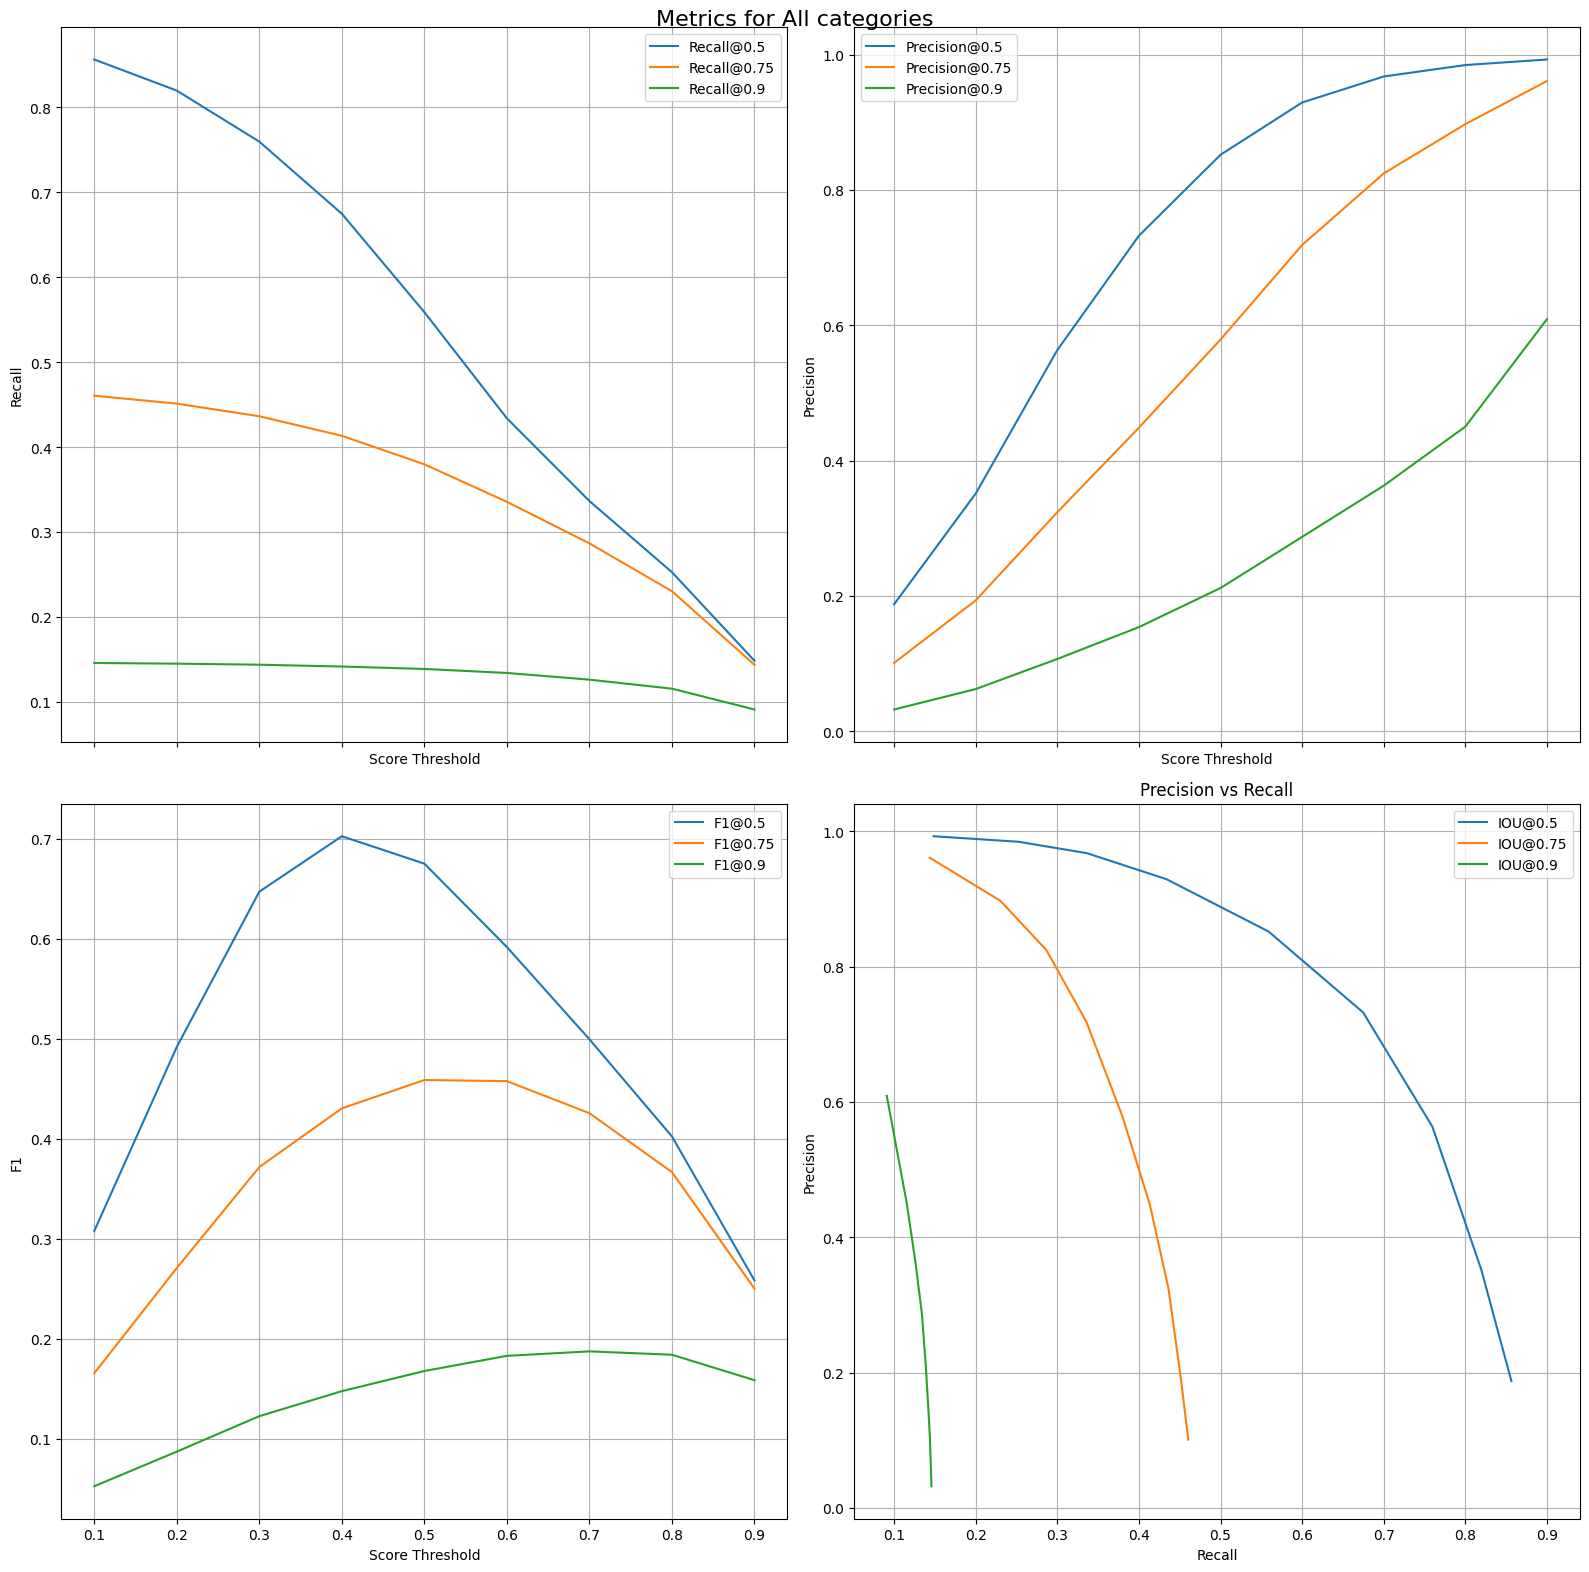

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(16, 16), sharex='col')
fig.suptitle("Metrics for All categories", fontsize=16)

metrics = ['Recall', 'Precision', 'F1']

for idx, metric in enumerate(metrics):
    for iou_threshold in iou_thresholds:
        curr_iou_metrics = metrics_df[(metrics_df['category'] == 'all') & (metrics_df['iou_threshold'] == iou_threshold)]
        metric_vals = [curr_iou_metrics[curr_iou_metrics['score_threshold'] == score_threshold]['metrics'].values[0][metric.lower()] for score_threshold in score_thresholds]
        axs[idx // 2, idx % 2].plot(score_thresholds, metric_vals, label=f"{metric}@{iou_threshold}")
    
    axs[idx // 2, idx % 2].set_ylabel(metric)
    axs[idx // 2, idx % 2].set_xlabel("Score Threshold")
    axs[idx // 2, idx % 2].legend()
    axs[idx // 2, idx % 2].grid(True)

# Add precision vs recall plot
for iou_threshold in iou_thresholds:
    curr_iou_metrics = metrics_df[(metrics_df['category'] == 'all') & (metrics_df['iou_threshold'] == iou_threshold)]
    precision_vals = [curr_iou_metrics[curr_iou_metrics['score_threshold'] == score_threshold]['metrics'].values[0]['precision'] for score_threshold in score_thresholds]
    recall_vals = [curr_iou_metrics[curr_iou_metrics['score_threshold'] == score_threshold]['metrics'].values[0]['recall'] for score_threshold in score_thresholds]
    axs[1, 1].plot(recall_vals, precision_vals, label=f"IOU@{iou_threshold}")

axs[1, 1].set_xlabel("Recall")
axs[1, 1].set_ylabel("Precision")
axs[1, 1].set_title("Precision vs Recall")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


Categories: ['all' 'train' 'bike' 'truck' 'bus' 'person' 'motor' 'rider' 'car'
 'traffic light' 'traffic sign']


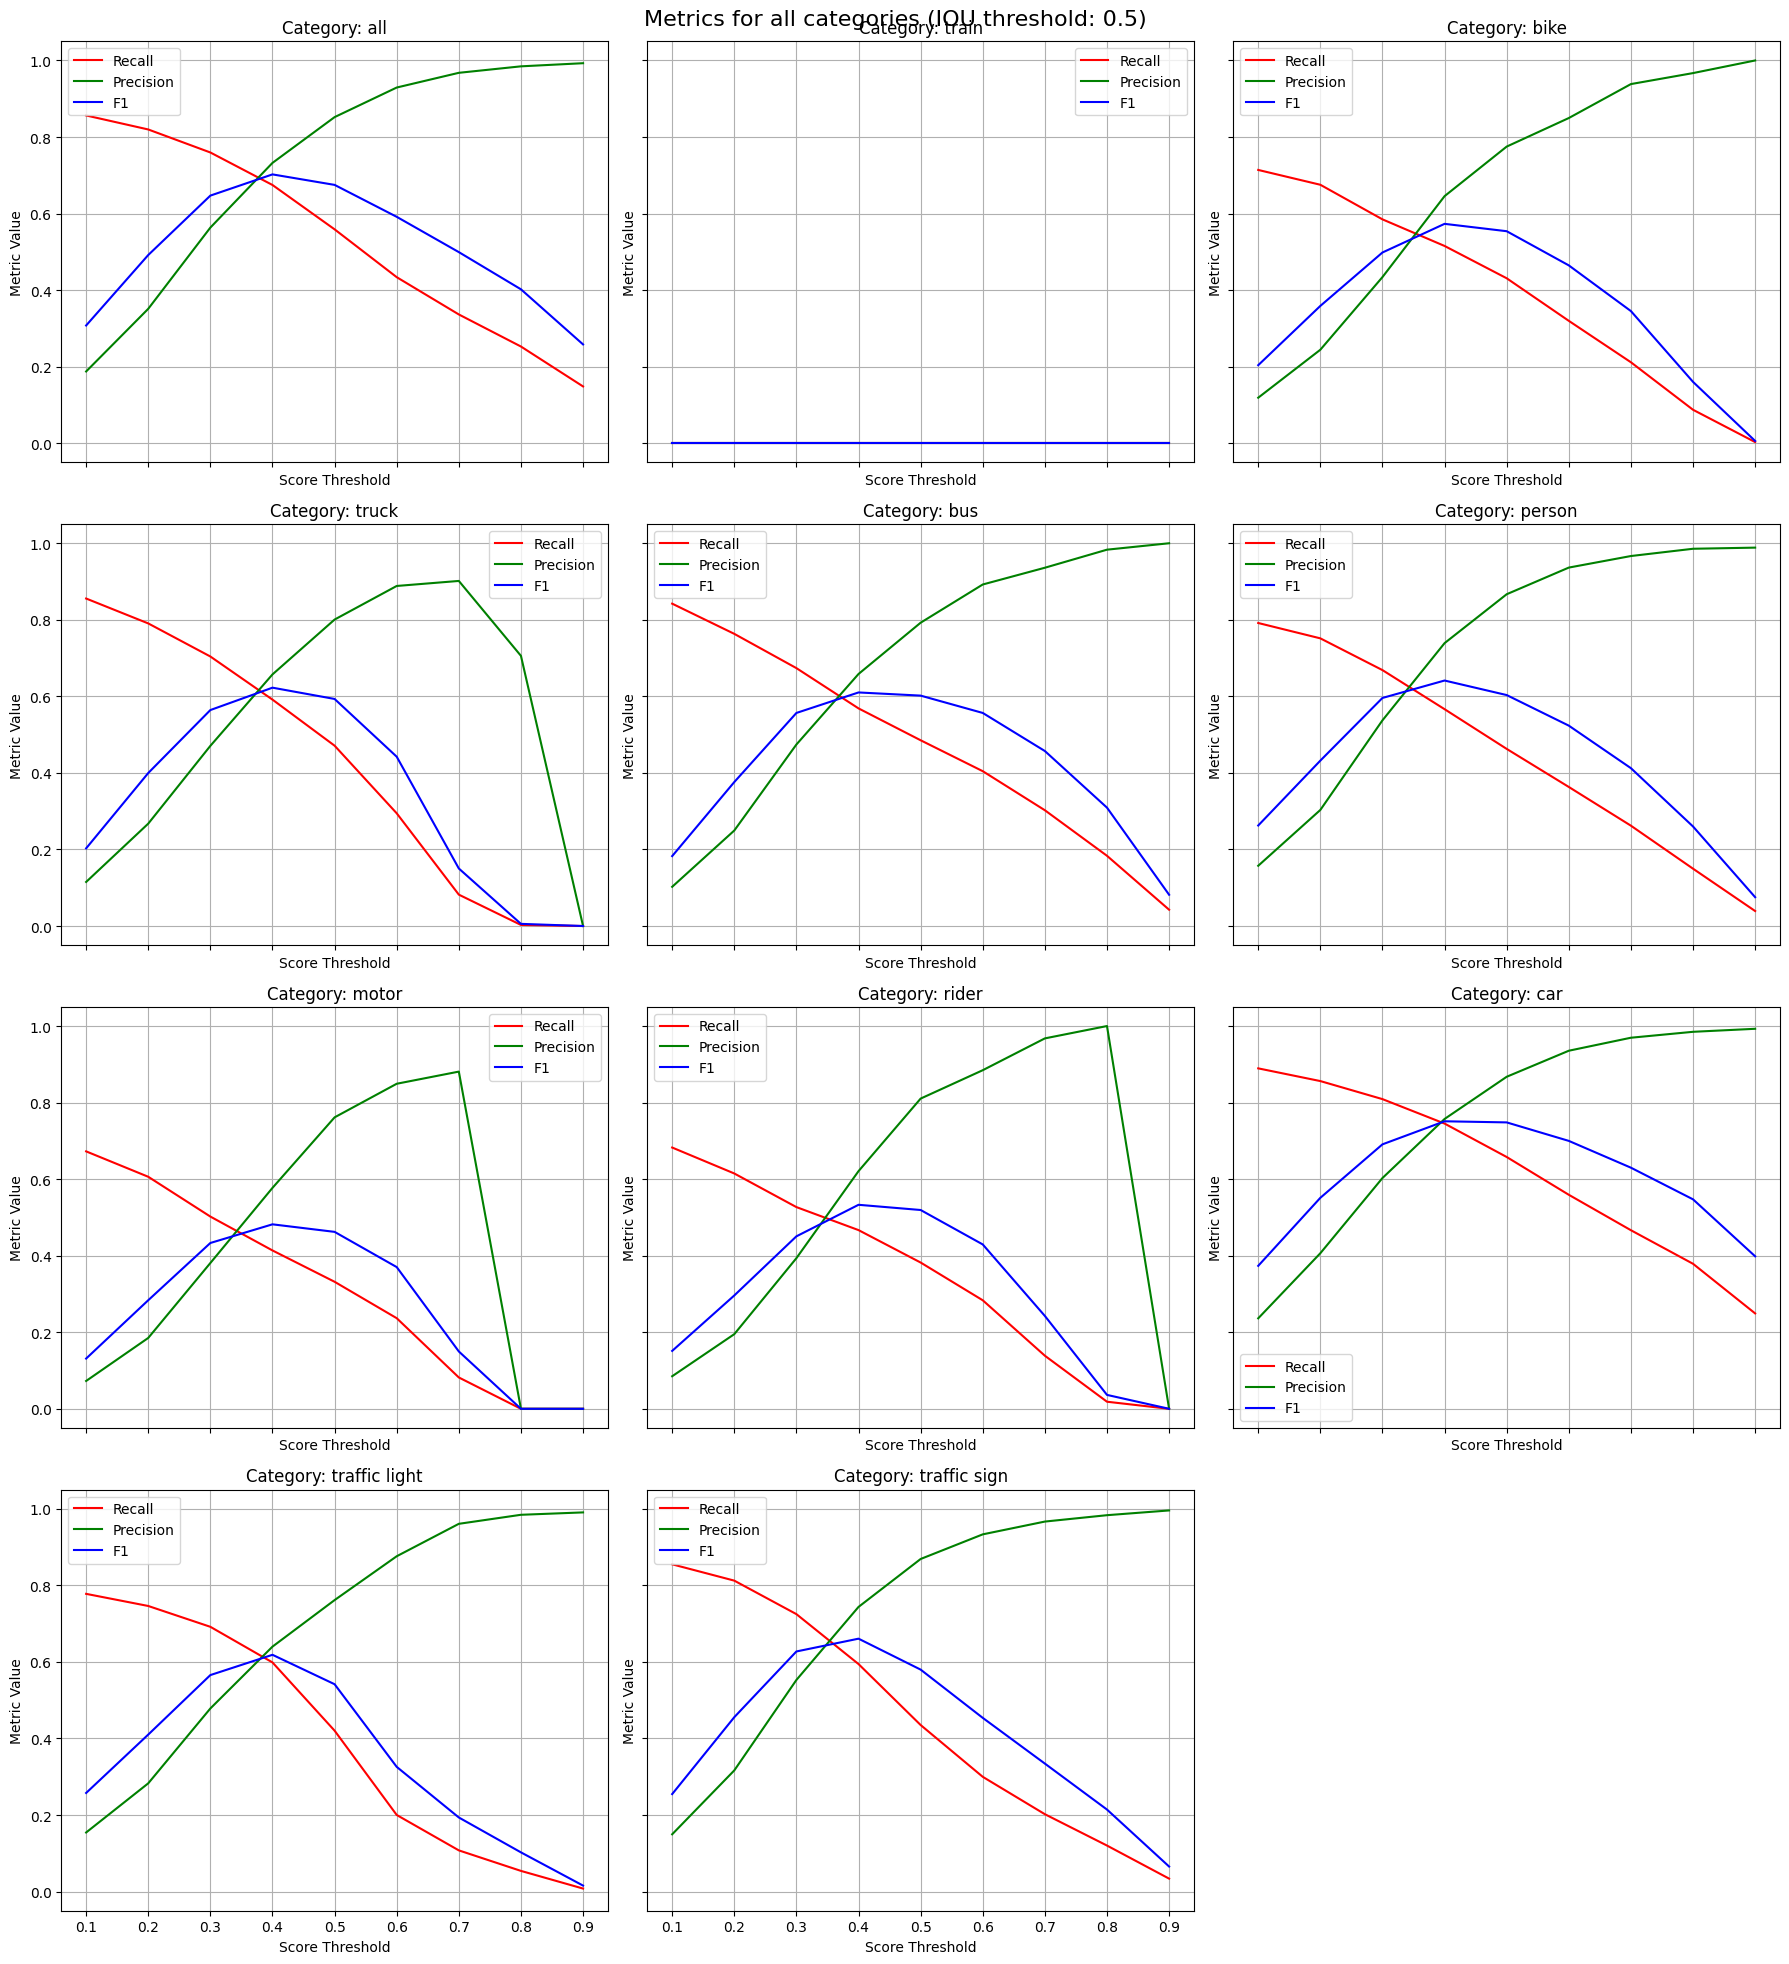

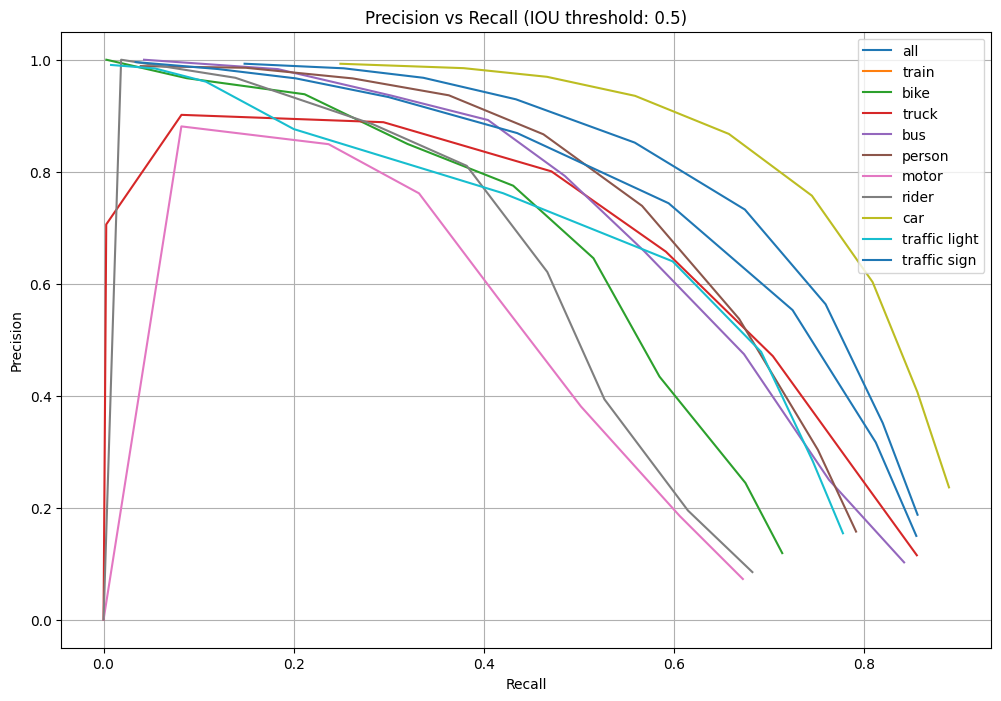

In [6]:
categories = metrics_df['category'].unique()
print(f"Categories: {categories}")

iou_threshold = 0.5

n_categories = len(categories)
n_cols = 3  
n_rows = (n_categories + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharex=True, sharey=True)
fig.suptitle(f"Metrics for all categories (IOU threshold: {iou_threshold})", fontsize=16)

metrics = ['Recall', 'Precision', 'F1']
colors = ['r', 'g', 'b']

for idx, category in enumerate(categories):
    row = idx // n_cols
    col = idx % n_cols
    
    curr_metrics = metrics_df[(metrics_df['category'] == category) & (metrics_df['iou_threshold'] == iou_threshold)]
    
    for metric, color in zip(metrics, colors):
        metric_vals = [curr_metrics[curr_metrics['score_threshold'] == score_threshold]['metrics'].values[0][metric.lower()] for score_threshold in score_thresholds]
        axs[row, col].plot(score_thresholds, metric_vals, color=color, label=metric)
    
    axs[row, col].set_title(f"Category: {category}")
    axs[row, col].set_xlabel("Score Threshold")
    axs[row, col].set_ylabel("Metric Value")
    axs[row, col].legend()
    axs[row, col].grid(True)

for idx in range(n_categories, n_rows * n_cols):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

# Separate Precision vs Recall plot for all categories
plt.figure(figsize=(12, 8))
for category in categories:
    curr_metrics = metrics_df[(metrics_df['category'] == category) & (metrics_df['iou_threshold'] == iou_threshold)]
    precision_vals = [curr_metrics[curr_metrics['score_threshold'] == score_threshold]['metrics'].values[0]['precision'] for score_threshold in score_thresholds]
    recall_vals = [curr_metrics[curr_metrics['score_threshold'] == score_threshold]['metrics'].values[0]['recall'] for score_threshold in score_thresholds]
    plt.plot(recall_vals, precision_vals, label=category)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision vs Recall (IOU threshold: {iou_threshold})")
plt.legend()
plt.grid(True)
plt.show()


# Max F1 Score

Now we will find the point at which the F1 score is the maximum. This way we can set the working point of the model where it performs the best.
We can even set a different working point based on the needs of the model. If its an autolabelling model with other modules on top (like tracking etc) we can even set the models here to high recall, and then improve the precision in the post-process.

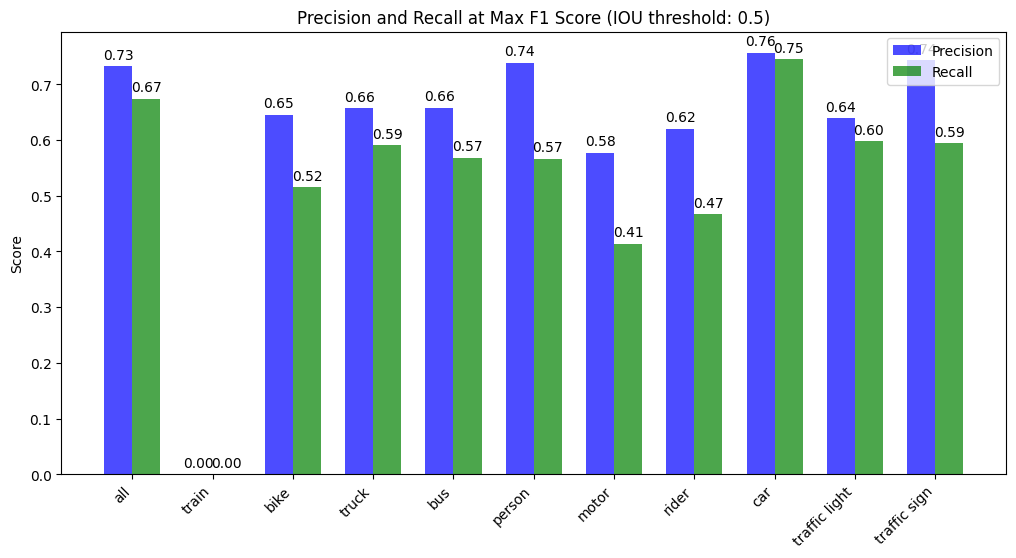

In [7]:
iou_threshold = 0.5

categories = metrics_df['category'].unique()

results = {}

for category in categories:
    curr_metrics = metrics_df[(metrics_df['category'] == category) & (metrics_df['iou_threshold'] == iou_threshold)]
    f1_scores = [curr_metrics[curr_metrics['score_threshold'] == score_threshold]['metrics'].values[0]['f1'] for score_threshold in score_thresholds]
    max_f1_index = np.argmax(f1_scores)
    max_f1_score_threshold = score_thresholds[max_f1_index]
    
    max_f1_metrics = curr_metrics[curr_metrics['score_threshold'] == max_f1_score_threshold]['metrics'].values[0]
    results[category] = {
        'max_f1': max_f1_metrics['f1'],
        'precision': max_f1_metrics['precision'],
        'recall': max_f1_metrics['recall'],
        'score_threshold': max_f1_score_threshold
    }

categories_plot = list(results.keys())
precisions = [results[cat]['precision'] for cat in categories_plot]
recalls = [results[cat]['recall'] for cat in categories_plot]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(categories_plot))
width = 0.35

rects1 = ax.bar(x - width/2, precisions, width, label='Precision', color='b', alpha=0.7)
rects2 = ax.bar(x + width/2, recalls, width, label='Recall', color='g', alpha=0.7)

ax.set_ylabel('Score')
ax.set_title(f'Precision and Recall at Max F1 Score (IOU threshold: {iou_threshold})')
ax.set_xticks(x)
ax.set_xticklabels(categories_plot, rotation=45, ha='right')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.subplots_adjust(left=0.2, bottom=0.2)

plt.show()


# Average Precision Analysis

In this section, we will see how each class performs on the most commonly used metric - AP. 
This gives us an overview of the model performance with one number

In [8]:
# Lets load the metrics from the pretrained model

with open('/Users/ashutoshtaklikar/Desktop/Bosch_Interview/bdd_object_detection/retinanet_r50_fpn_3x_det_bdd100k.json', 'r') as f:
    results = json.load(f)

In [9]:
def plot_individual_bar_charts(results):
    """
    Generates individual bar charts for each metric category (AP, AP50, etc.).

    Args:
        results (dict): A dictionary containing the evaluation results.
    """
    metric_categories = ["AP", "AP50", "AP75", "AP_small", "AP_medium", "AP_large", "AR1", "AR10", "AR100", "AR_small", "AR_medium", "AR_large"]
    class_names = list(results["AP"][0].keys()) 
    class_names = [name.capitalize() for name in class_names]

    for metric_name in metric_categories:
        if metric_name not in results:
            print(f"Metric category '{metric_name}' not found in results.")
            continue

        category_results = results[metric_name][0]
        if not category_results:
            print(f"No class-wise results found for '{metric_name}'.")
            continue

        metric_values = [category_results.get(class_name.lower(), 0) for class_name in class_names]

        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(class_names, metric_values, color='skyblue')

        ax.set_xlabel("Object Class")
        ax.set_ylabel(metric_name)
        ax.set_title(f"{metric_name} per Object Class")
        ax.set_ylim([0, 100])
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 1), ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


def plot_grouped_ap_iou(results):
    """
    Generates a grouped bar chart comparing AP, AP50, and AP75 for each object class.

    Args:
        results (dict): A dictionary containing the evaluation results.
    """
    iou_metrics = ["AP", "AP50", "AP75"]
    class_names = list(results["AP"][0].keys())
    class_names = [name.capitalize() for name in class_names]

    n_classes = len(class_names)
    n_metrics = len(iou_metrics)
    bar_width = 0.25

    fig, ax = plt.subplots(figsize=(12, 7))
    x = np.arange(n_classes)

    colors = ['skyblue', 'lightcoral', 'lightgreen']

    for i, metric_name in enumerate(iou_metrics):
        metric_values = [results[metric_name][0].get(class_name.lower(), 0) for class_name in class_names]
        ax.bar(x + i * bar_width, metric_values, bar_width, label=metric_name, color=colors[i])

    ax.set_xlabel("Object Class")
    ax.set_ylabel("Average Precision (AP)")
    ax.set_title("AP Comparison at Different IoU Thresholds")
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim([0, 100])
    ax.legend(title="IoU Metric")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


def plot_grouped_ar_detections(results):
    """
    Generates a grouped bar chart comparing AR1, AR10, and AR100 for each object class.

    Args:
        results (dict): A dictionary containing the evaluation results.
    """
    ar_metrics = ["AR1", "AR10", "AR100"]
    class_names = list(results["AR1"][0].keys())
    class_names = [name.capitalize() for name in class_names]

    n_classes = len(class_names)
    n_metrics = len(ar_metrics)
    bar_width = 0.25

    fig, ax = plt.subplots(figsize=(12, 7))
    x = np.arange(n_classes)

    colors = ['skyblue', 'lightcoral', 'lightgreen']

    for i, metric_name in enumerate(ar_metrics):
        metric_values = [results[metric_name][0].get(class_name.lower(), 0) for class_name in class_names]
        ax.bar(x + i * bar_width, metric_values, bar_width, label=metric_name, color=colors[i])

    ax.set_xlabel("Object Class")
    ax.set_ylabel("Average Recall (AR)")
    ax.set_title("AR Comparison at Different Number of Detections")
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim([0, 100])
    ax.legend(title="Max Detections")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


def plot_overall_metric_comparison(results):
    """
    Generates a bar chart comparing the "OVERALL" values for different metrics.

    Args:
        results (dict): A dictionary containing the evaluation results.
    """
    overall_metrics = [
        "AP", "AP50", "AP75", "AP_small", "AP_medium", "AP_large",
        "AR1", "AR10", "AR100", "AR_small", "AR_medium", "AR_large"
    ]
    overall_values = []
    metric_labels = []

    for metric_name in overall_metrics:
        if metric_name in results and len(results[metric_name]) > 1 and "OVERALL" in results[metric_name][1]:
            overall_values.append(results[metric_name][1]["OVERALL"])
            metric_labels.append(f"{metric_name} Overall")
        else:
            print(f"Overall value for '{metric_name}' not found in results.")

    if not overall_values:
        print("No overall metric values found to plot.")
        return

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metric_labels, overall_values, color='purple')

    ax.set_xlabel("Metric")
    ax.set_ylabel("Overall Value")
    ax.set_title("Overall Performance Metric Comparison")
    ax.set_ylim([0, 100])
    plt.xticks(rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 1), ha='center', va='bottom')


    plt.tight_layout()
    plt.show()



# AP per filters

Here we plot the AP for each object class.

We look at different metrics - See how the model performs over different IOU thresholds - 50%, 75%

We also see how the model performs over different box sizes - Small (32^2), Medium (32^2 - 96^2), Large (>96^2)

Along with that, we see AR (Average Recall) metrics over 1/10/100 boxes


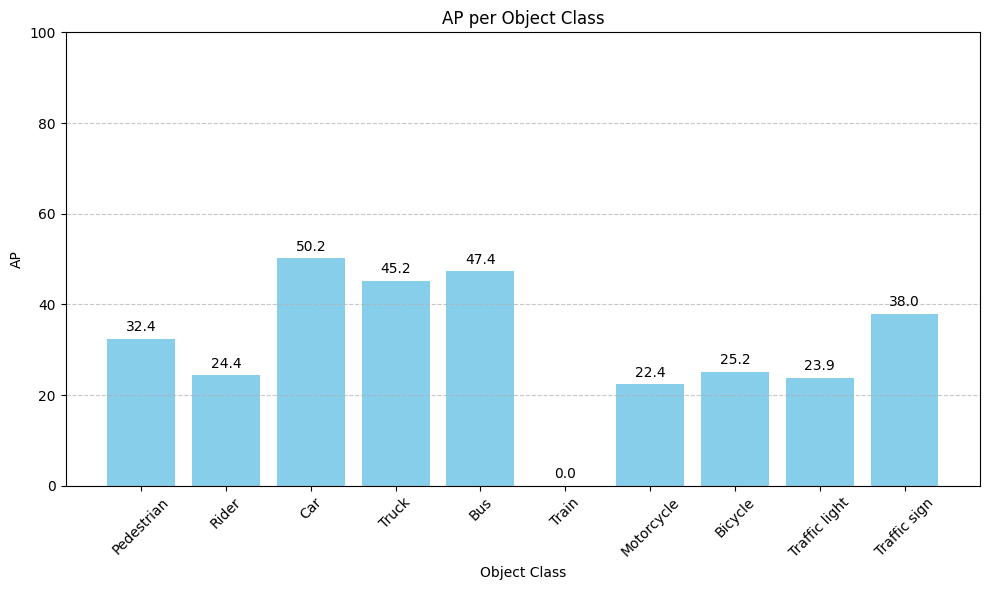

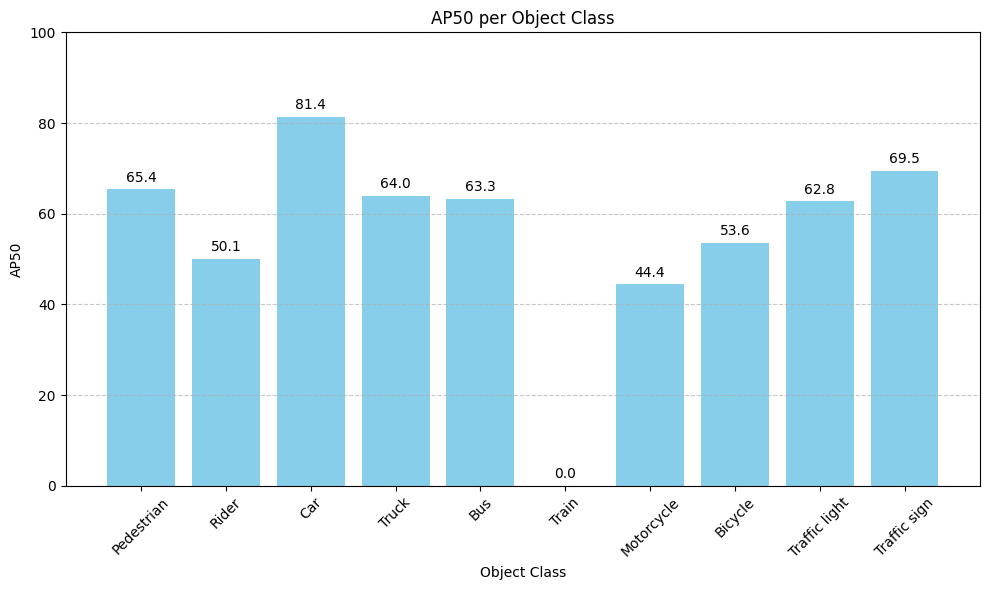

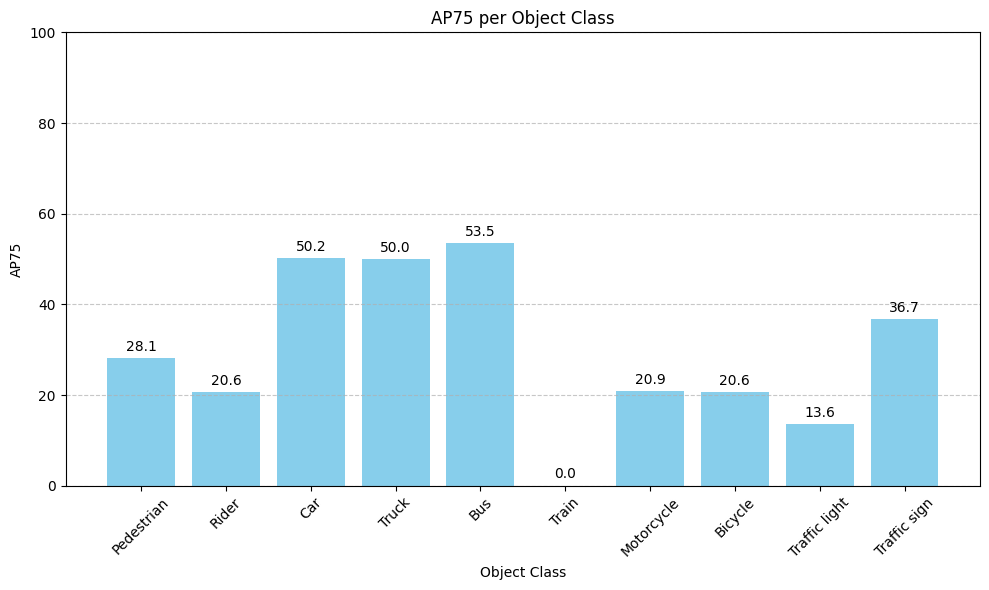

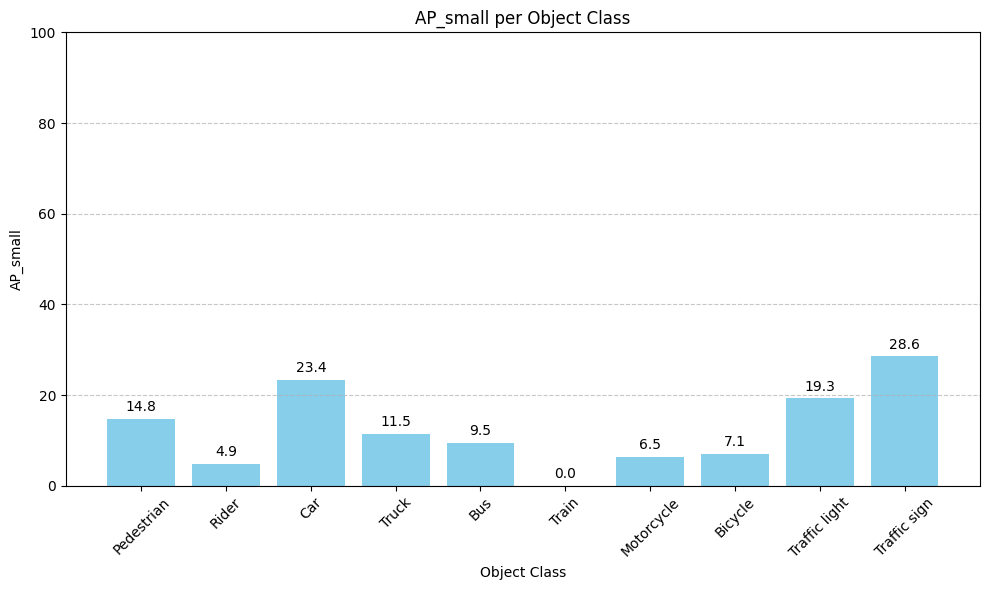

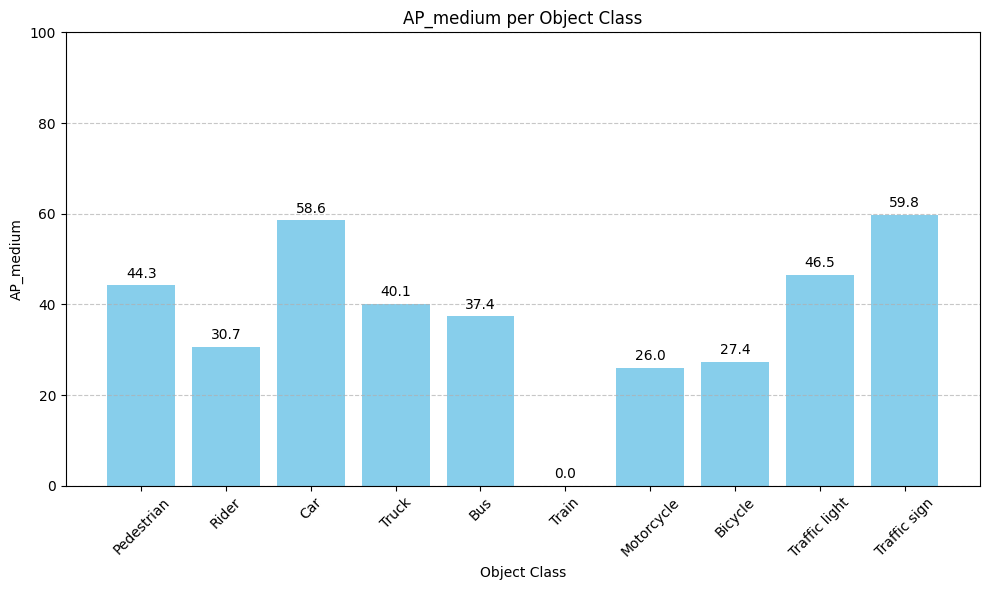

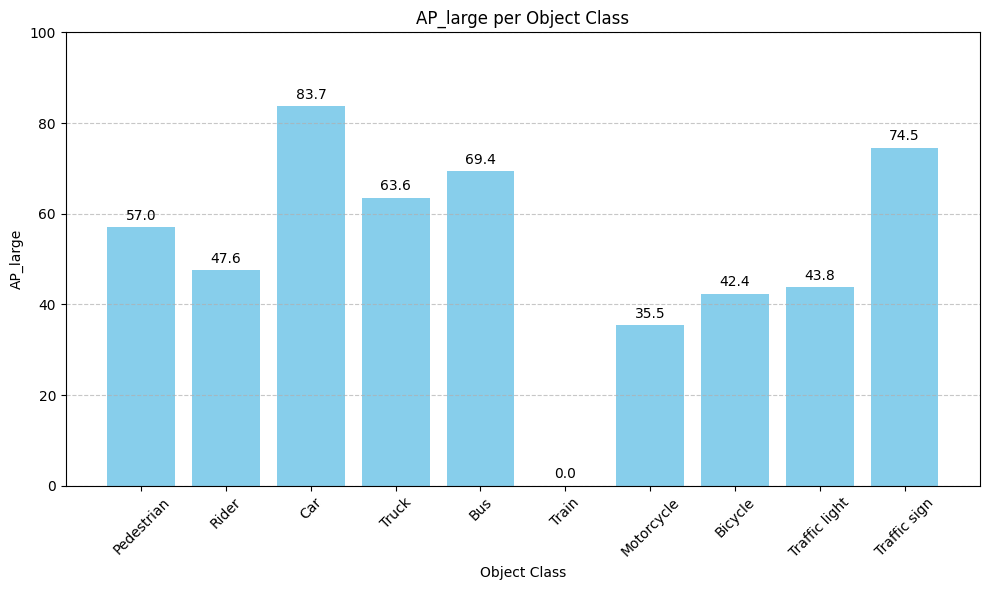

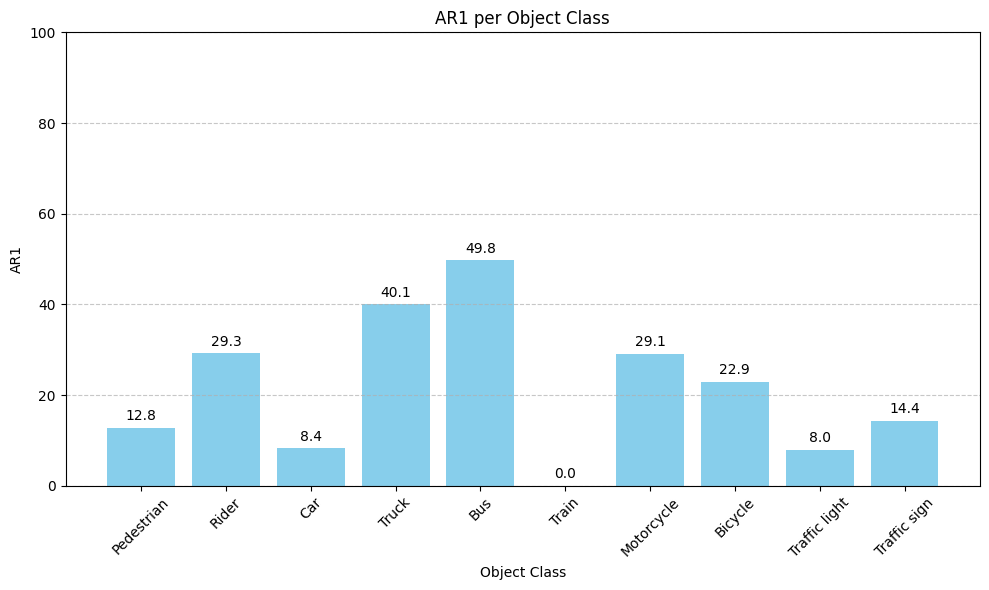

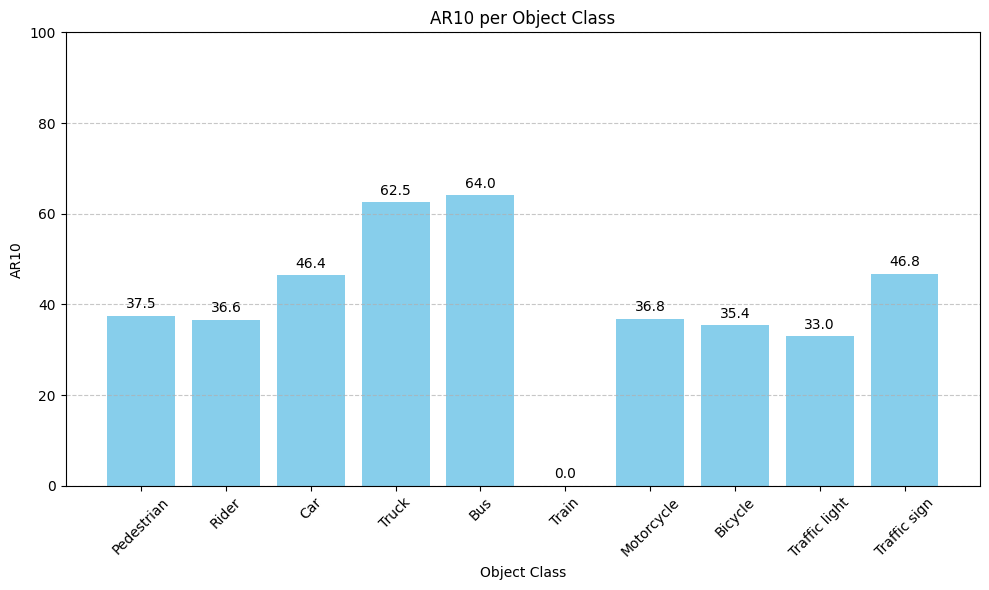

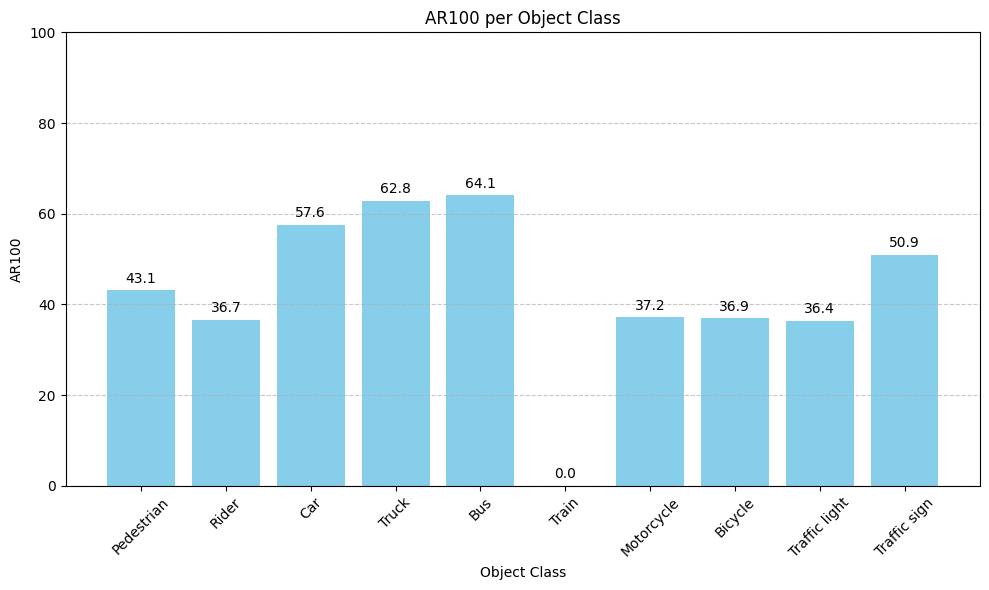

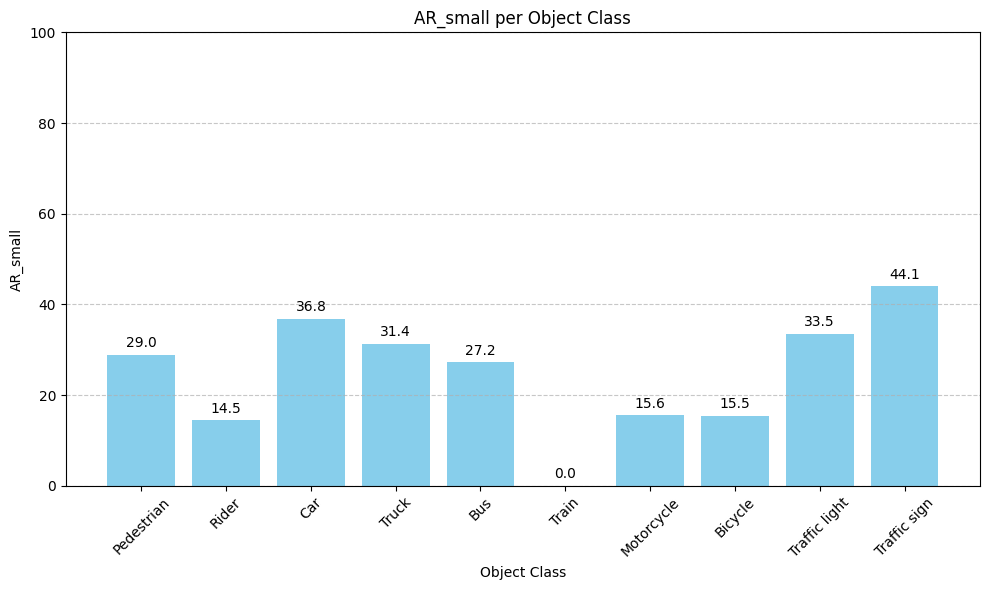

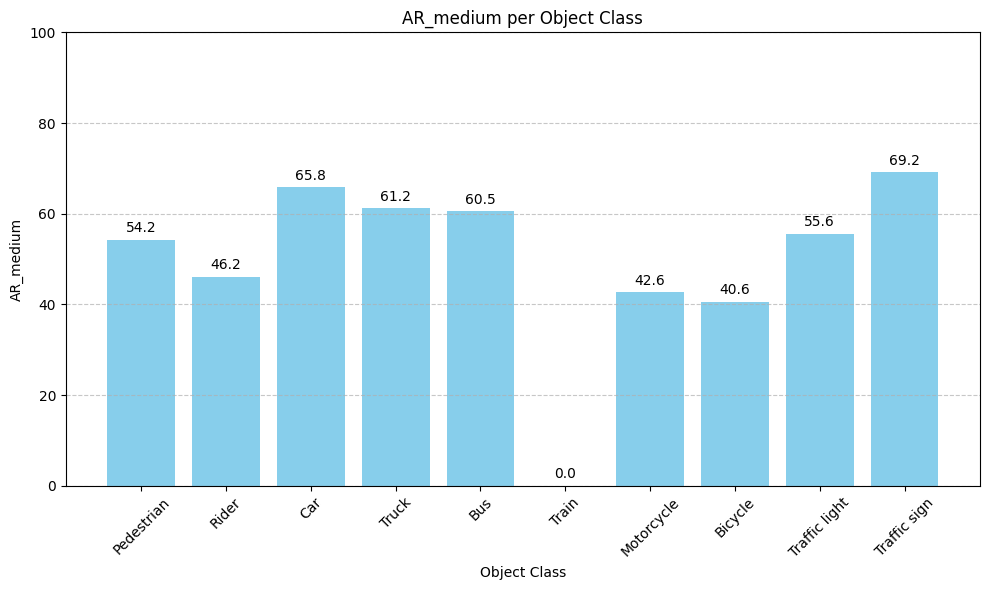

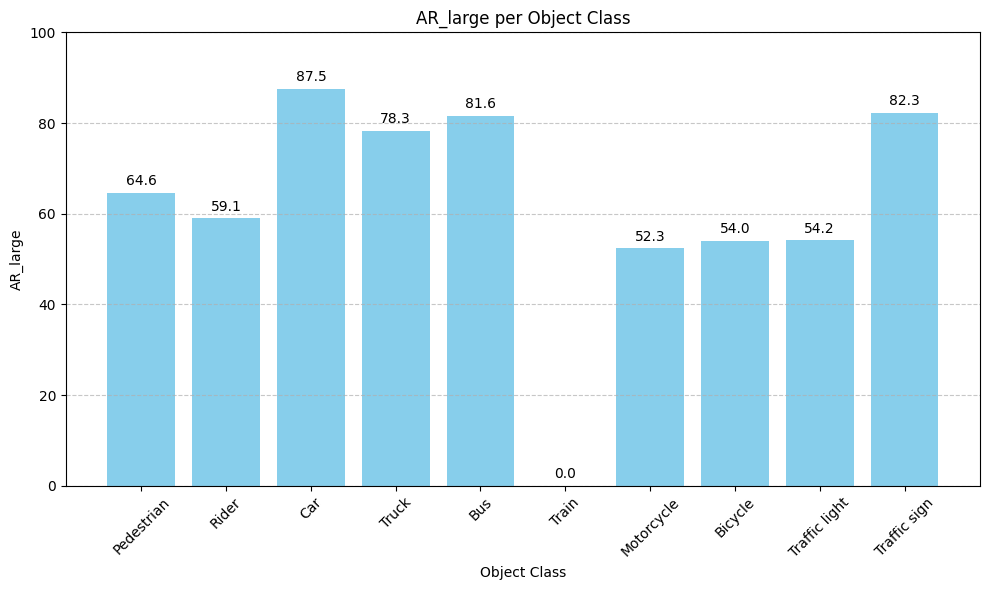

In [10]:
plot_individual_bar_charts(results)

# IOU Thresholds

We now look at different IOU thresholds and how the model performs at those.

Usually 0.5 is considered good for object detection, however in more cruicial applications like Autonomous cars, we would like a higher threshold of 75% or even 90%.

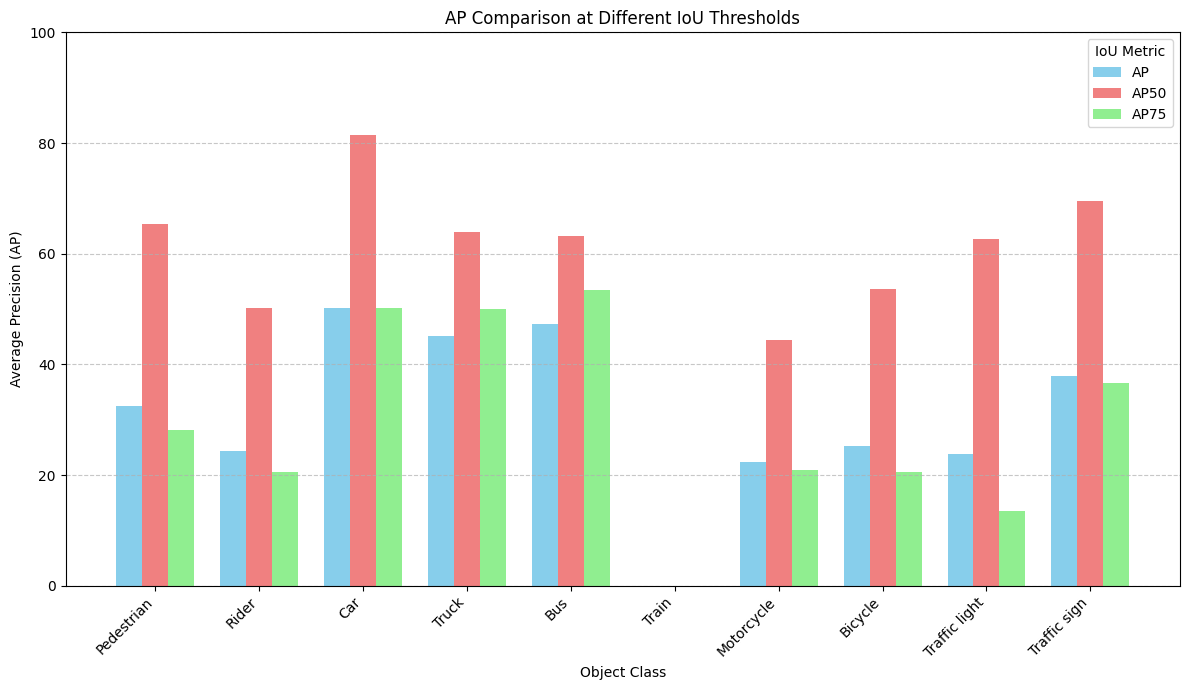

In [11]:
plot_grouped_ap_iou(results)

# AR Analysis

Here we try to see if we underconfident in our detections. So if we detect more boxes, does it benifit us.

This is more useful when we have robust postprocessing methods to clean up the detections later.

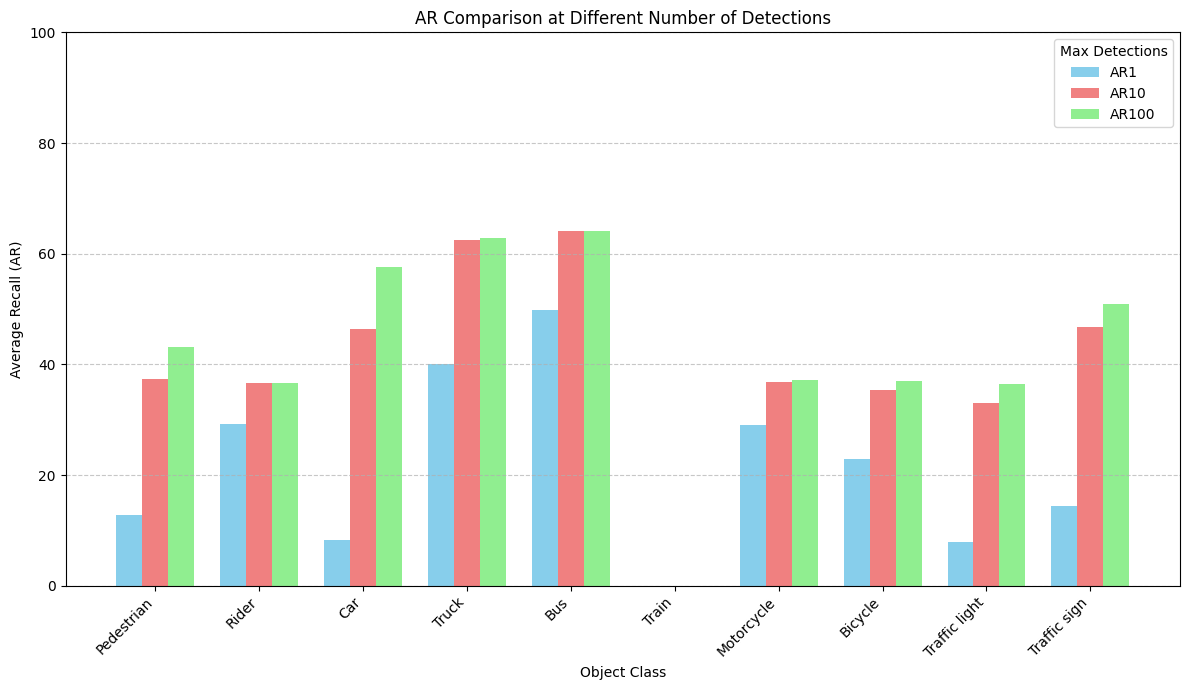

In [12]:
plot_grouped_ar_detections(results)

# Overall Analysis

Here we present an overview of all the metrics mentioned above.

This is done over all classes together and can give us a better idea of the model

However, considering the applications, we can be more sensitive to some classes than others, and doing an object based analysis is more fruitful.


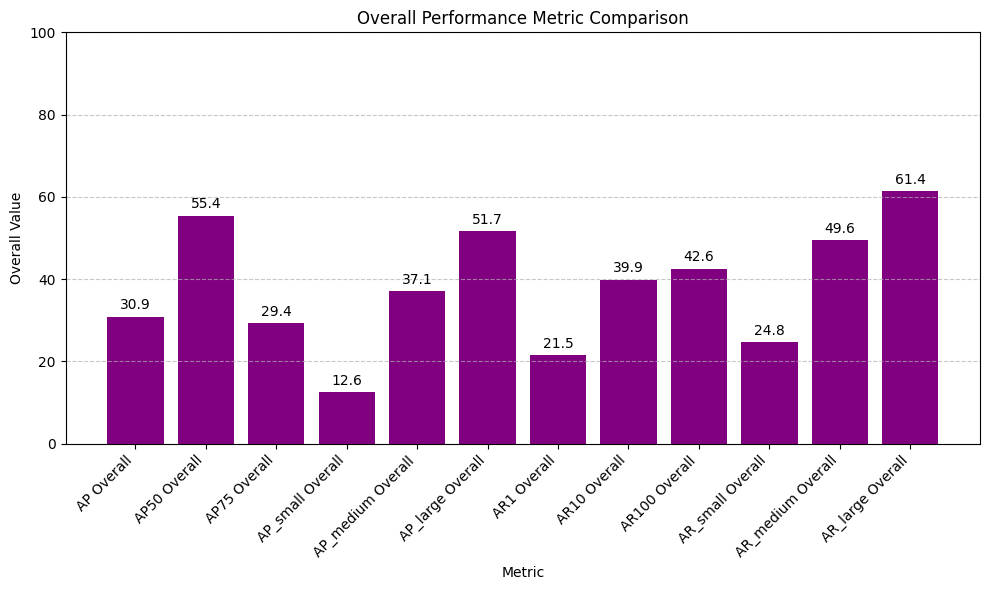

In [13]:
plot_overall_metric_comparison(results)